## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

env = TicTacToe()

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
epsilon_list = []
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    epsilon_list.append(epsilon)
    z = np.random.random()
    # print(z)
    # print(epsilon)
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    #Picking any 4 random q values
    sample_q_values = [([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],(2, 9)),
                      ([6, np.nan, np.nan, np.nan, 3, np.nan, np.nan, np.nan, np.nan],(7, 5)),
                      ([np.nan, np.nan, np.nan, np.nan, np.nan, 8, 7, np.nan, np.nan],(8, 9)),
                      ([np.nan,2, np.nan, np.nan, 1, np.nan, np.nan, np.nan, np.nan],(5, 3))]

    for q_values in sample_q_values:
        state = Q_state(q_values[0]) #state string
        action = q_values[1]
        States_track[state][action] = []  

In [8]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [11]:
threshold = 2000 # no of episodes after which states_tracked will be saved
policy_threshold = 4000 # no of episodes after which Q dictionary/table will be saved
policy_update_len = 2000

STEPS = 15
LR = 0.01 # learning rate
GAMMA = 0.9 # discount factor
EPISODES = policy_threshold * policy_update_len

### Q-update loop ---write your code here

In [12]:
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.000001 # epsilon decay rate

In [13]:
start_time = time.time()
res_list = [0,0,0]
win_list = []

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary

    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon function
        next_state, reward, done, win_code = env.step(curr_state, curr_action) # getting rewards and win code
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)

        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
    
    #tracking number of wins,losses,ties
    res_list = [res_list[i] + win_code[i] for i in range(len(win_code))]
    #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracked')
       
    if ((episode+1)%(policy_threshold*policy_update_len/100))==0:
        win_list.append((res_list[2]/(episode+1)*100))
        #printing evert 10000th episode
        print("Episode:%d, Win%%:%0.2f, Loss%%:%0.2f, Tie%%:%0.2f"%((episode+1),(res_list[2]/(episode+1)*100), (res_list[0]/(episode+1)*100),(res_list[1]/(episode+1)*100)))

    if ((episode+1)% policy_threshold) == 0:
        save_obj(Q_dict,'Policy_Q_dict')
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print("Timetaken:%d mins %d seconds"%(elapsed_time/60,elapsed_time%60))


Episode:80000, Win%:24.88, Loss%:28.32, Tie%:46.80
Episode:160000, Win%:25.11, Loss%:28.34, Tie%:46.55
Episode:240000, Win%:25.31, Loss%:28.24, Tie%:46.45
Episode:320000, Win%:25.59, Loss%:28.18, Tie%:46.23
Episode:400000, Win%:25.91, Loss%:28.00, Tie%:46.10
Episode:480000, Win%:26.33, Loss%:27.77, Tie%:45.90
Episode:560000, Win%:26.73, Loss%:27.58, Tie%:45.69
Episode:640000, Win%:27.18, Loss%:27.32, Tie%:45.50
Episode:720000, Win%:27.64, Loss%:27.12, Tie%:45.23
Episode:800000, Win%:28.18, Loss%:26.87, Tie%:44.95
Episode:880000, Win%:28.69, Loss%:26.64, Tie%:44.66
Episode:960000, Win%:29.22, Loss%:26.41, Tie%:44.37
Episode:1040000, Win%:29.78, Loss%:26.17, Tie%:44.05
Episode:1120000, Win%:30.34, Loss%:25.96, Tie%:43.70
Episode:1200000, Win%:30.90, Loss%:25.75, Tie%:43.34
Episode:1280000, Win%:31.50, Loss%:25.52, Tie%:42.98
Episode:1360000, Win%:32.07, Loss%:25.30, Tie%:42.63
Episode:1440000, Win%:32.65, Loss%:25.08, Tie%:42.27
Episode:1520000, Win%:33.26, Loss%:24.85, Tie%:41.89
Episod

#### Check the Q-dictionary

In [14]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -1.27211210801656,
              (0, 3): -1.3457144239994843,
              (0, 5): -1.3822182243358838,
              (0, 7): -1.3412143932554828,
              (0, 9): 5.285668024710516,
              (1, 1): -0.7601446717939505,
              (1, 3): -1.2756713666196526,
              (1, 5): 0.8002474998112744,
              (1, 7): -1.2460323782532923,
              (1, 9): -1.2754106305284942,
              (2, 1): -0.7398542582852112,
              (2, 3): -1.2920404817653341,
              (2, 5): -1.2884921560964253,
              (2, 7): -1.307666130668088,
              (2, 9): -1.3333529233106032,
              (3, 1): -1.1591056569292313,
              (3, 3): -1.2967293799995288,
              (3, 5): -1.2646097977599768,
              (3, 7): -1.2784933247549886,
              (3, 9): -1.2984356314859522,
              (4, 1): -1.3504016746629521,
              (4, 3): -1.3812190299077782,
              (4, 5):

In [15]:
len(Q_dict)

2272216

In [16]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
#STATE : '1-3-7-5-2-6-x-8-4' agent thinks best action is to place value 9 at position 6
Q_dict['1-3-7-5-2-6-x-8-4']

{(6, 9): 0.29701}

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [17]:
# Write the code for plotting the graphs for state-action pairs tracked

<function matplotlib.pyplot.show(*args, **kw)>

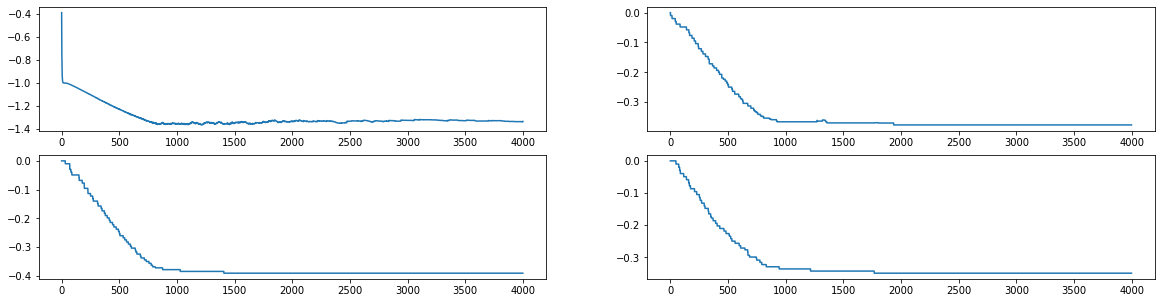

In [18]:
plt.figure(0, figsize=(20,5))

key1 = list(States_track.keys())[0]
key2 = list(States_track[key1].keys())[0]
x_axis = np.asarray(range(0, len(States_track[key1][key2])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track[key1][key2]))
plt.show

key1 = list(States_track.keys())[1]
key2 = list(States_track[key1].keys())[0]
x_axis = np.asarray(range(0, len(States_track[key1][key2])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track[key1][key2]))
plt.show

key1 = list(States_track.keys())[2]
key2 = list(States_track[key1].keys())[0]
x_axis = np.asarray(range(0, len(States_track[key1][key2])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track[key1][key2]))
plt.show

key1 = list(States_track.keys())[3]
key2 = list(States_track[key1].keys())[0]
x_axis = np.asarray(range(0, len(States_track[key1][key2])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track[key1][key2]))
plt.show

## Plotting Agent win% vs episode

<function matplotlib.pyplot.show(*args, **kw)>

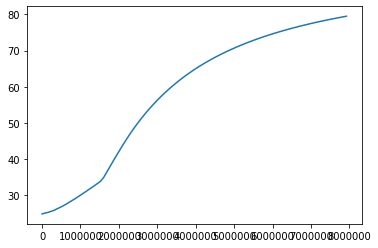

In [19]:
y_axis = np.asarray(win_list) # win accuracy on y axis
x_axis = np.asarray(range(1, policy_threshold*policy_update_len, int(policy_threshold*policy_update_len/100)))
plt.subplot(111)
plt.plot(x_axis,y_axis)
plt.show

### Epsilon - decay check

In [20]:
time = np.arange(0,len(epsilon_list))

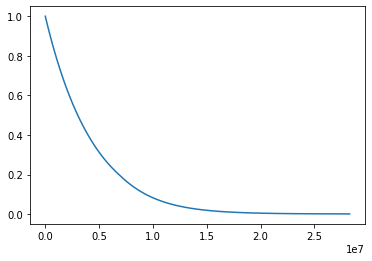

In [21]:
plt.plot(time, epsilon_list)
plt.show()